<a href="https://colab.research.google.com/github/giuseppemartino26/Semantic-SAM/blob/main/Semantic_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import csv

drive.mount('/content/drive')

matrix_path = '/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/img_matrix/2007_000033.npy' #semantic segmentation predictions
img_path = '/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/JPEGImages/2007_000033.jpg'
ground_truth = '/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/SegmentationClass/2007_000033.png'

Mounted at /content/drive


Rimuoviamo la color map dalle annotazioni del ground truth

In [2]:
# TOGLIAMO LA COLOR MAP
import numpy as np
from PIL import Image

# Carica l'immagine di segmentazione true
image_path = ground_truth
segmentation_true = Image.open(image_path)

# Converti l'immagine in una matrice numpy
segmentation_array = np.array(segmentation_true)

# Mappa i valori dei pixel agli indici di classe (0-20)
class_matrix = segmentation_array.astype(int) 


# Visualizza la matrice con le classi di segmentazione
print(class_matrix)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [3]:
np.unique(class_matrix)

array([  0,   1, 255])

In [4]:
class_matrix.shape

(366, 500)

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [5]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [6]:
using_colab = True

In [7]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: True
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-55nl9qrn
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-55nl9qrn
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=b3ca888ad1b5efcff77cd5979e7759fb997981669b75db31b75e3ceb1e23a6f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-tplxj0_f/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segm

## Set-up

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [9]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [10]:
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

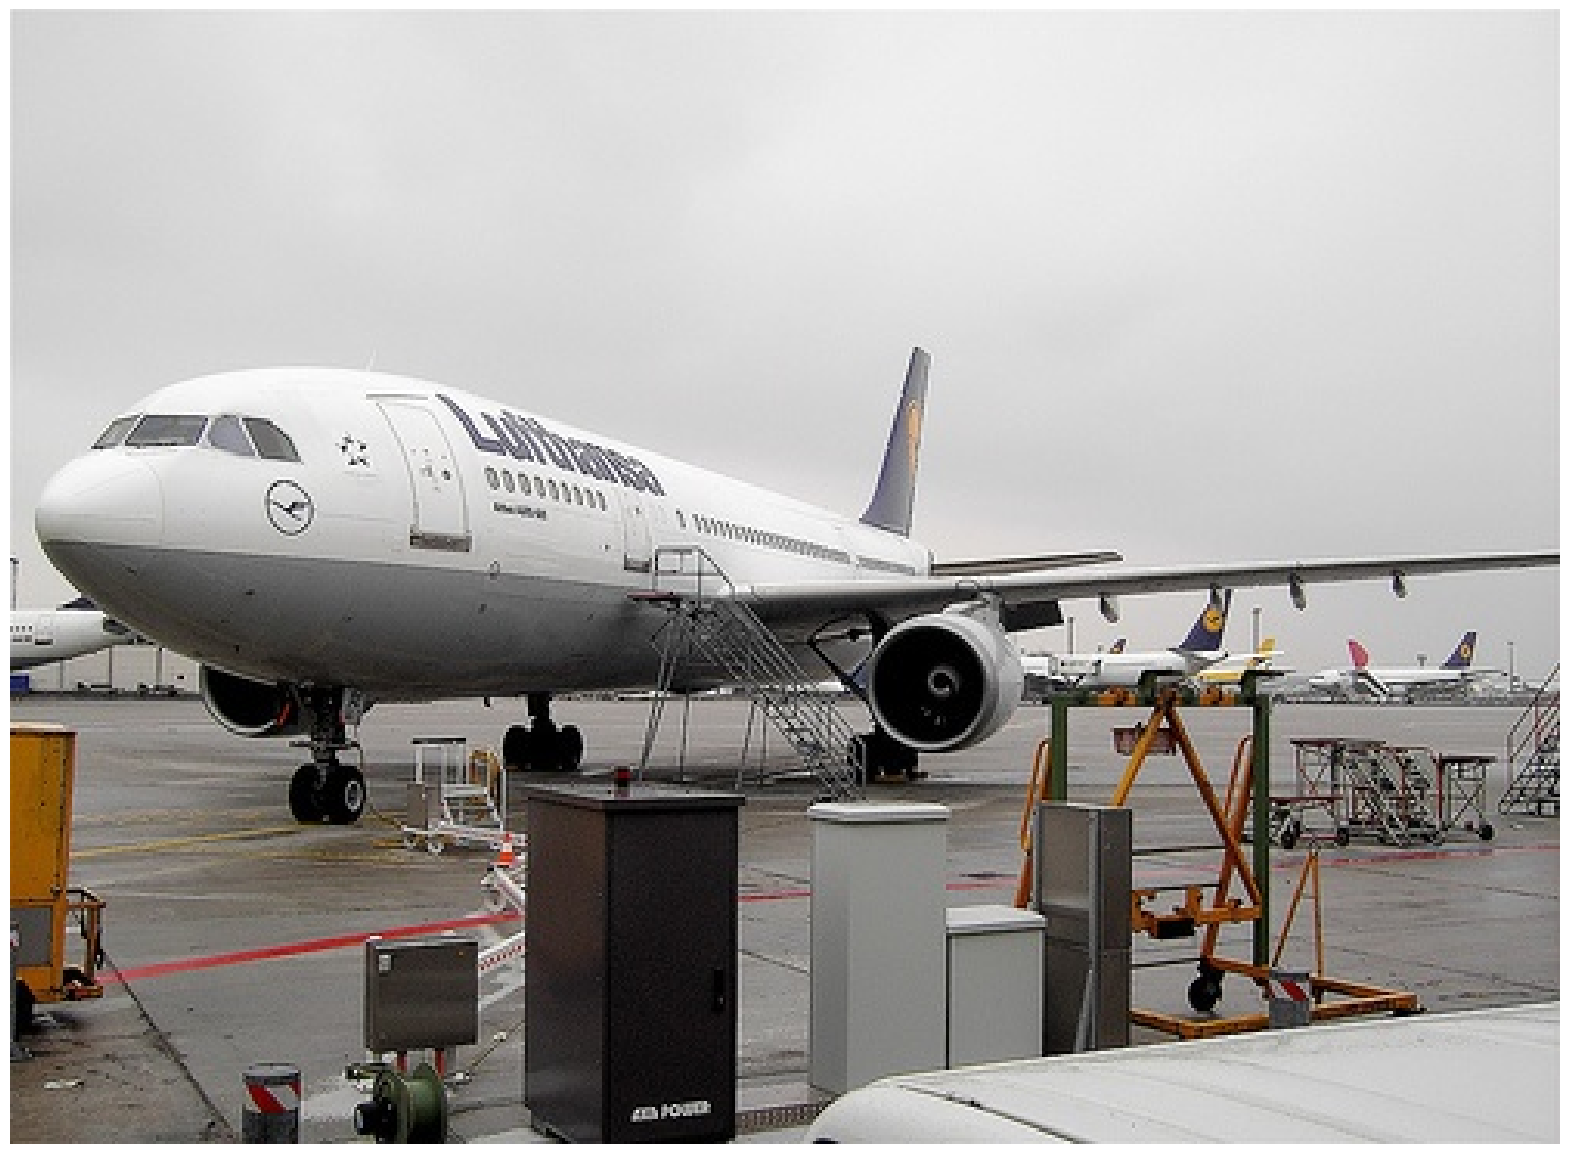

In [11]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [23]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [24]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [25]:
print(len(masks))
print(masks[0].keys())

99
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

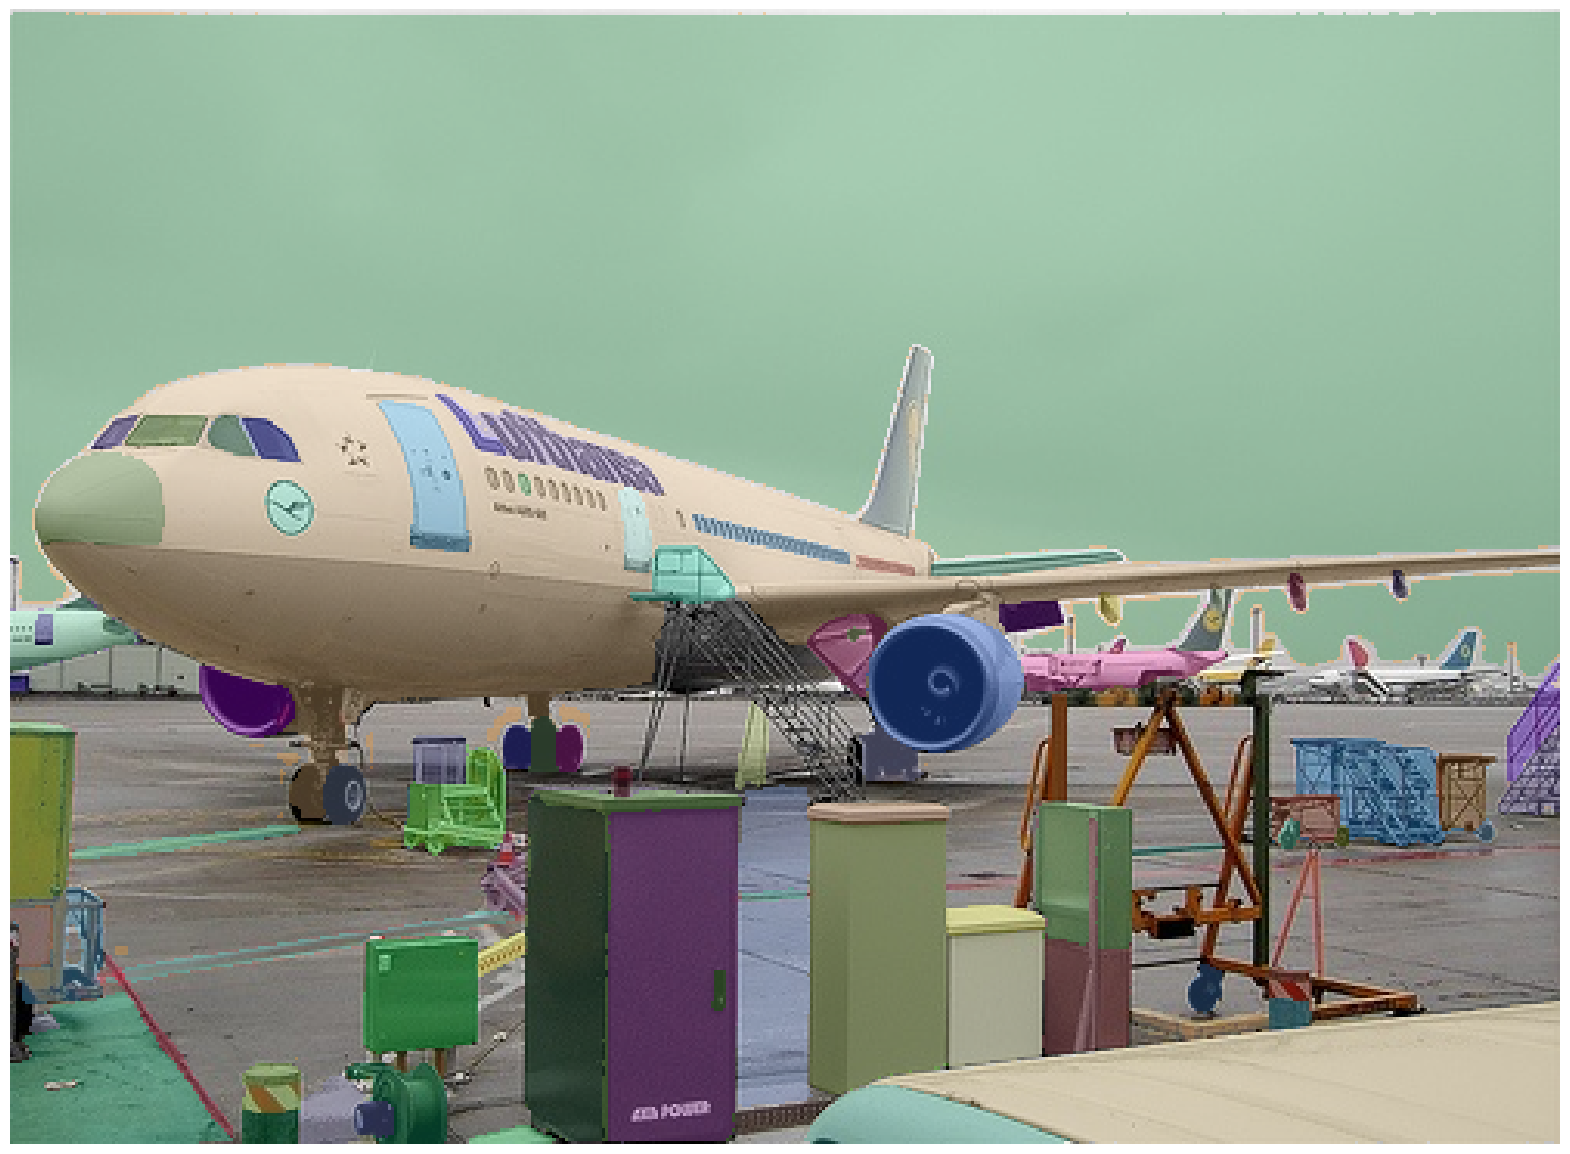

In [26]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

carichiamo le prediction della segmentazione semantica

In [48]:
img_seg = np.load(matrix_path)
img_seg_dpt = img_seg
img_seg_dpt

array([[ 3,  3,  3, ...,  3,  3,  3],
       [ 3,  3,  3, ...,  3,  3,  3],
       [ 3,  3,  3, ...,  3,  3,  3],
       ...,
       [55, 55, 55, ..., 91, 91, 91],
       [55, 55, 55, ..., 91, 91, 91],
       [55, 55, 55, ..., 91, 91, 91]])

In [49]:
total_classes = np.unique(img_seg_dpt)
print(total_classes)
print(len(total_classes))

[ 3 21 41 55 91]
5


In [50]:
dict_class = dict.fromkeys(total_classes, 0)
dict_class

{3: 0, 21: 0, 41: 0, 55: 0, 91: 0}

In [51]:
#Popoliamo un dict_class per ogni maschera dell'immagine. vect_dict è un array di dict_class
vect_dict = []
for mask in masks:
  dict_class = dict.fromkeys(total_classes, 0)
  for raw in range(0,len(mask['segmentation'])):
    for col in range(0,len(mask['segmentation'][raw])):
      if mask['segmentation'][raw][col]:
        dict_class[img_seg[raw][col]] += 1
  vect_dict.append(dict_class)

In [52]:
vect_dict[0]

{3: 0, 21: 2574, 41: 0, 55: 2443, 91: 2741}

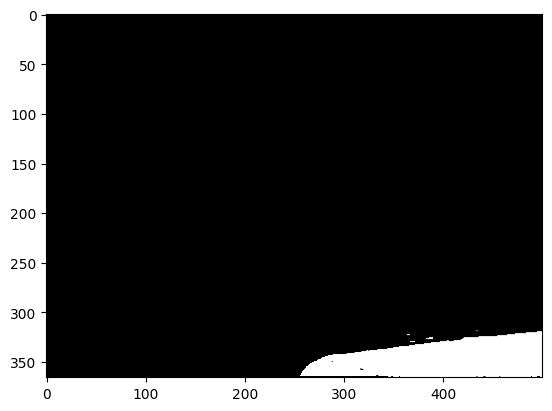

In [32]:
#plottiamo una mask
plt.imshow(masks[0]['segmentation'], cmap='gray')
plt.show()

In [53]:
max_classes = [] #la classe di ogni maschera
for dict_mask in vect_dict:
  max_classes.append(max(dict_mask,key=dict_mask.get))

In [54]:
max_classes[0]

91

91 è la classe della prima maschera dell'immagine

In [55]:
i = 0
for mask in masks:
  for raw in range(0,len(mask['segmentation'])):
    for col in range(0,len(mask['segmentation'][raw])):
      if mask['segmentation'][raw][col]:
        img_seg[raw][col] = max_classes[i]
  i += 1
        

In [56]:
img_seg

array([[ 3,  3,  3, ...,  3,  3,  3],
       [ 3,  3,  3, ...,  3,  3,  3],
       [ 3,  3,  3, ...,  3,  3,  3],
       ...,
       [55, 55, 55, ..., 91, 91, 91],
       [55, 55, 55, ..., 91, 91, 91],
       [55, 55, 55, ..., 91, 91, 91]])

In [ ]:
len(img_seg[0])

500

###Per visualizzare il risultato finale, sovrapponiamo all'immagine originale la segmentazione finale ottenuta

In [37]:
def _get_voc_pallete(num_cls):
    n = num_cls
    pallete = [0]*(n*3)
    for j in range(0,n):
            lab = j
            pallete[j*3+0] = 0
            pallete[j*3+1] = 0
            pallete[j*3+2] = 0
            i = 0
            while (lab > 0):
                    pallete[j*3+0] |= (((lab >> 0) & 1) << (7-i))
                    pallete[j*3+1] |= (((lab >> 1) & 1) << (7-i))
                    pallete[j*3+2] |= (((lab >> 2) & 1) << (7-i))
                    i = i + 1
                    lab >>= 3
    return pallete

In [38]:
vocpallete = _get_voc_pallete(256)

adepallete = [0,0,0,120,120,120,180,120,120,6,230,230,80,50,50,4,200,3,120,120,80,140,140,140,204,5,255,230,230,230,4,250,7,224,5,255,235,255,7,150,5,61,120,120,70,8,255,51,255,6,82,143,255,140,204,255,4,255,51,7,204,70,3,0,102,200,61,230,250,255,6,51,11,102,255,255,7,71,255,9,224,9,7,230,220,220,220,255,9,92,112,9,255,8,255,214,7,255,224,255,184,6,10,255,71,255,41,10,7,255,255,224,255,8,102,8,255,255,61,6,255,194,7,255,122,8,0,255,20,255,8,41,255,5,153,6,51,255,235,12,255,160,150,20,0,163,255,140,140,140,250,10,15,20,255,0,31,255,0,255,31,0,255,224,0,153,255,0,0,0,255,255,71,0,0,235,255,0,173,255,31,0,255,11,200,200,255,82,0,0,255,245,0,61,255,0,255,112,0,255,133,255,0,0,255,163,0,255,102,0,194,255,0,0,143,255,51,255,0,0,82,255,0,255,41,0,255,173,10,0,255,173,255,0,0,255,153,255,92,0,255,0,255,255,0,245,255,0,102,255,173,0,255,0,20,255,184,184,0,31,255,0,255,61,0,71,255,255,0,204,0,255,194,0,255,82,0,10,255,0,112,255,51,0,255,0,194,255,0,122,255,0,255,163,255,153,0,0,255,10,255,112,0,143,255,0,82,0,255,163,255,0,255,235,0,8,184,170,133,0,255,0,255,92,184,0,255,255,0,31,0,184,255,0,214,255,255,0,112,92,255,0,0,224,255,112,224,255,70,184,160,163,0,255,153,0,255,71,255,0,255,0,163,255,204,0,255,0,143,0,255,235,133,255,0,255,0,235,245,0,255,255,0,122,255,245,0,10,190,212,214,255,0,0,204,255,20,0,255,255,255,0,0,153,255,0,41,255,0,255,204,41,0,255,41,255,0,173,0,255,0,245,255,71,0,255,122,0,255,0,255,184,0,92,255,184,255,0,0,133,255,255,214,0,25,194,194,102,255,0,92,0,255]

citypallete = [
128,64,128,244,35,232,70,70,70,102,102,156,190,153,153,153,153,153,250,170,30,220,220,0,107,142,35,152,251,152,70,130,180,220,20,60,255,0,0,0,0,142,0,0,70,0,60,100,0,80,100,0,0,230,119,11,32,128,192,0,0,64,128,128,64,128,0,192,128,128,192,128,64,64,0,192,64,0,64,192,0,192,192,0,64,64,128,192,64,128,64,192,128,192,192,128,0,0,64,128,0,64,0,128,64,128,128,64,0,0,192,128,0,192,0,128,192,128,128,192,64,0,64,192,0,64,64,128,64,192,128,64,64,0,192,192,0,192,64,128,192,192,128,192,0,64,64,128,64,64,0,192,64,128,192,64,0,64,192,128,64,192,0,192,192,128,192,192,64,64,64,192,64,64,64,192,64,192,192,64,64,64,192,192,64,192,64,192,192,192,192,192,32,0,0,160,0,0,32,128,0,160,128,0,32,0,128,160,0,128,32,128,128,160,128,128,96,0,0,224,0,0,96,128,0,224,128,0,96,0,128,224,0,128,96,128,128,224,128,128,32,64,0,160,64,0,32,192,0,160,192,0,32,64,128,160,64,128,32,192,128,160,192,128,96,64,0,224,64,0,96,192,0,224,192,0,96,64,128,224,64,128,96,192,128,224,192,128,32,0,64,160,0,64,32,128,64,160,128,64,32,0,192,160,0,192,32,128,192,160,128,192,96,0,64,224,0,64,96,128,64,224,128,64,96,0,192,224,0,192,96,128,192,224,128,192,32,64,64,160,64,64,32,192,64,160,192,64,32,64,192,160,64,192,32,192,192,160,192,192,96,64,64,224,64,64,96,192,64,224,192,64,96,64,192,224,64,192,96,192,192,224,192,192,0,32,0,128,32,0,0,160,0,128,160,0,0,32,128,128,32,128,0,160,128,128,160,128,64,32,0,192,32,0,64,160,0,192,160,0,64,32,128,192,32,128,64,160,128,192,160,128,0,96,0,128,96,0,0,224,0,128,224,0,0,96,128,128,96,128,0,224,128,128,224,128,64,96,0,192,96,0,64,224,0,192,224,0,64,96,128,192,96,128,64,224,128,192,224,128,0,32,64,128,32,64,0,160,64,128,160,64,0,32,192,128,32,192,0,160,192,128,160,192,64,32,64,192,32,64,64,160,64,192,160,64,64,32,192,192,32,192,64,160,192,192,160,192,0,96,64,128,96,64,0,224,64,128,224,64,0,96,192,128,96,192,0,224,192,128,224,192,64,96,64,192,96,64,64,224,64,192,224,64,64,96,192,192,96,192,64,224,192,192,224,192,32,32,0,160,32,0,32,160,0,160,160,0,32,32,128,160,32,128,32,160,128,160,160,128,96,32,0,224,32,0,96,160,0,224,160,0,96,32,128,224,32,128,96,160,128,224,160,128,32,96,0,160,96,0,32,224,0,160,224,0,32,96,128,160,96,128,32,224,128,160,224,128,96,96,0,224,96,0,96,224,0,224,224,0,96,96,128,224,96,128,96,224,128,224,224,128,32,32,64,160,32,64,32,160,64,160,160,64,32,32,192,160,32,192,32,160,192,160,160,192,96,32,64,224,32,64,96,160,64,224,160,64,96,32,192,224,32,192,96,160,192,224,160,192,32,96,64,160,96,64,32,224,64,160,224,64,32,96,192,160,96,192,32,224,192,160,224,192,96,96,64,224,96,64,96,224,64,224,224,64,96,96,192,224,96,192,96,224,192,0,0,0]


In [39]:
def get_mask_pallete(npimg, dataset='detail'):
    """Get image color pallete for visualizing masks"""
    # recovery boundary
    if dataset == 'pascal_voc':
        npimg[npimg==21] = 255
    # put colormap
    out_img = Image.fromarray(npimg.squeeze().astype('uint8'))
    if dataset == 'ade20k':
        out_img.putpalette(adepallete)
    elif dataset == 'citys':
        out_img.putpalette(citypallete)
    elif dataset in ('detail', 'pascal_voc', 'pascal_aug'):
        out_img.putpalette(vocpallete)
    return out_img

In [40]:
from PIL import Image

def write_segm_img(path, image, labels, palette="detail", alpha=0.5):
    """Write depth map to pfm and png file.

    Args:
        path (str): filepath without extension
        image (array): input image
        labels (array): labeling of the image
    """

    mask = get_mask_pallete(labels, "ade20k")

    img = Image.fromarray(np.uint8(255*image)).convert("RGBA")
    seg = mask.convert("RGBA")

    out = Image.blend(img, seg, alpha)

    out.save(path + ".png")

    return

In [41]:
def read_image(path):
    """Read image and output RGB image (0-1).

    Args:
        path (str): path to file

    Returns:
        array: RGB image (0-1)
    """
    img = cv2.imread(path)

    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

    return img

In [57]:
img = read_image(img_path)

In [58]:
write_segm_img('/content/drive/MyDrive/ProgettoSEAI/data/pascal_voc/prova3', img, img_seg, alpha=0.5)

###calcoliamo **IOU** e **DICE** coefficient

In [59]:
for i in range(0,len(img_seg)):
  for j in range(0,len(img_seg[i])):

    if img_seg[i][j] == 91:
      img_seg[i][j] = 1
    else:
      img_seg[i][j] = 0

In [20]:
for i in range(0,len(img_seg_dpt)):
  for j in range(0,len(img_seg_dpt[i])):

    if img_seg_dpt[i][j] == 91:
      img_seg_dpt[i][j] = 1
    else:
      img_seg_dpt[i][j] = 0

In [15]:
def dice_coefficient(matrix1, matrix2):
  class_value = 1
  intersection= 0
  union = 0
  for i in range(0, len(matrix1)):
    for j in range (0, len(matrix1[i])):
      if matrix1[i][j] == 0 and  matrix2[i][j] == 0:
        continue
      if matrix1[i][j] == class_value:
        union +=1
      if  matrix2[i][j] == class_value:
        union +=1
      if matrix1[i][j] == matrix2[i][j]:
        intersection +=  1
  
  dice = (2.0 * intersection) / (union)
  #print(intersection)
  return dice

def iou(matrix1, matrix2):
  class_value = 1
  intersection= 0
  union = 0
  for i in range(0, len(matrix1)):
    for j in range (0, len(matrix1[i])):
      if matrix1[i][j] == 0 and  matrix2[i][j] == 0:
        continue
      if matrix1[i][j] == class_value or matrix2[i][j] == class_value:
        union +=1
      if matrix1[i][j] == matrix2[i][j]:
        intersection +=  1
  #print(union)   
  #print(intersection)
  iou = intersection / union
  return iou

In [21]:
print(f"IOU segmentazione semantica: {iou(class_matrix,img_seg_dpt)}")

IOU segmentazione semantica: 0.794853756865716


In [22]:
print(f"DICE segmentazione semantica: {dice_coefficient(class_matrix,img_seg_dpt)}")

DICE segmentazione semantica: 0.8857030873130728


In [60]:
print(f"IOU segmentazione finale: {iou(class_matrix,img_seg)}")

IOU segmentazione finale: 0.7396436525612472


In [61]:
print(f"DICE segmentazione finale: {dice_coefficient(class_matrix,img_seg)}")

DICE segmentazione finale: 0.8503392651389067
